## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
#設定超參數
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8]

In [7]:
results = {}

#使用迴圈建立不同的帶不同 L1/L2 的模型並訓練

for regulizer_ratio in L1_EXP:
    keras.backend.clear_session()
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Instructions for updati

50000/50000 [==============================] - 13s 269us/step - loss: 2.4626 - acc: 0.0981 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 48/50
50000/50000 [==============================] - 13s 263us/step - loss: 2.4626 - acc: 0.0983 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 13s 263us/step - loss: 2.4626 - acc: 0.0982 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 13s 266us/step - loss: 2.4626 - acc: 0.0984 - val_loss: 2.4626 - val_acc: 0.1000
Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dens

Epoch 48/50
50000/50000 [==============================] - 15s 305us/step - loss: 2.7110 - acc: 0.6278 - val_loss: 2.9533 - val_acc: 0.5329
Epoch 49/50
50000/50000 [==============================] - 14s 287us/step - loss: 2.6709 - acc: 0.6294 - val_loss: 2.9556 - val_acc: 0.5285
Epoch 50/50
50000/50000 [==============================] - 14s 287us/step - loss: 2.6375 - acc: 0.6310 - val_loss: 2.9410 - val_acc: 0.5204
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (

Epoch 49/50
50000/50000 [==============================] - 16s 316us/step - loss: 0.8983 - acc: 0.6839 - val_loss: 1.4252 - val_acc: 0.5212
Epoch 50/50
50000/50000 [==============================] - 17s 344us/step - loss: 0.8789 - acc: 0.6906 - val_loss: 1.3983 - val_acc: 0.5291


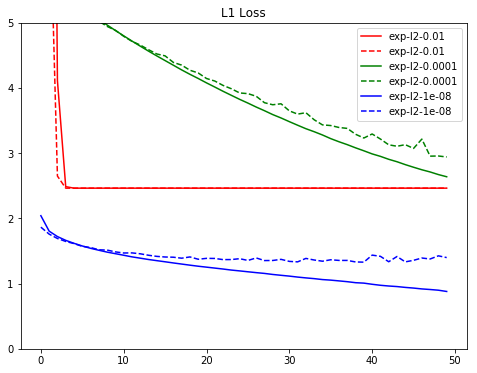

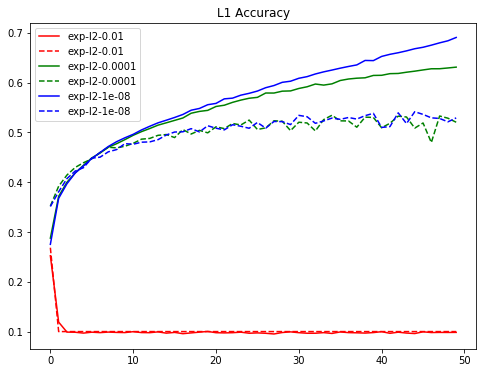

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("L1 Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("L1 Accuracy")
plt.legend()
plt.show()

In [16]:
#L1_L2
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [17]:
#設定超參數
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_L2_EXP = [1e-2, 1e-4, 1e-8]

In [18]:
results = {}

#使用迴圈建立不同的帶不同 L1/L2 的模型並訓練

for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session()
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 15s 296us/step - loss: 18.8270 - acc: 0.2728 - val_loss: 17.3838 - val_acc: 0.3258
Epoch 2/50
50000/50000 [==============================] - 13s 268us/step - loss: 16.1628 - acc: 0.3501 - val_loss: 15.0007 - val_acc: 0.3651
Epoch 3/50
50000/50000 [==============================] - 14s 271us/step - loss: 13.9756 - acc: 0.3736 - val_loss: 12.9949 - val_acc: 0.3809
Epoch 4/50
50000/50000 [==============================] - 13s 269us/step - loss: 12.1257 - acc: 0.3879 - val_loss: 11.2910 - val_acc: 0.3927
Epoch 5/50
50000/50000 [==============================] - 13s 269us/step - loss: 10.5534 - acc: 0.3972 - val_loss: 9.8521 - val_acc: 0.4000
Epoch 6/50
50000/50000 [==============================] - 13s 268us/step - loss: 9.2163 - acc: 0.4018 - val_loss: 8.6094 - val_acc: 0.4059
Epoch 7/50
50000/50000 [==============================] - 14s 274us/step - loss: 8.0750 - acc: 0.4095 - val

50000/50000 [==============================] - 15s 294us/step - loss: 15.0959 - acc: 0.2676 - val_loss: 13.9527 - val_acc: 0.3360
Epoch 2/50
50000/50000 [==============================] - 13s 269us/step - loss: 13.0187 - acc: 0.3595 - val_loss: 12.1280 - val_acc: 0.3701
Epoch 3/50
50000/50000 [==============================] - 13s 267us/step - loss: 11.3457 - acc: 0.3823 - val_loss: 10.6033 - val_acc: 0.3892
Epoch 4/50
50000/50000 [==============================] - 14s 270us/step - loss: 9.9349 - acc: 0.3963 - val_loss: 9.2925 - val_acc: 0.4038
Epoch 5/50
50000/50000 [==============================] - 13s 266us/step - loss: 8.7331 - acc: 0.4060 - val_loss: 8.1886 - val_acc: 0.4146
Epoch 6/50
50000/50000 [==============================] - 13s 270us/step - loss: 7.7106 - acc: 0.4143 - val_loss: 7.2495 - val_acc: 0.4163
Epoch 7/50
50000/50000 [==============================] - 13s 266us/step - loss: 6.8379 - acc: 0.4215 - val_loss: 6.4433 - val_acc: 0.4268
Epoch 8/50
50000/50000 [========

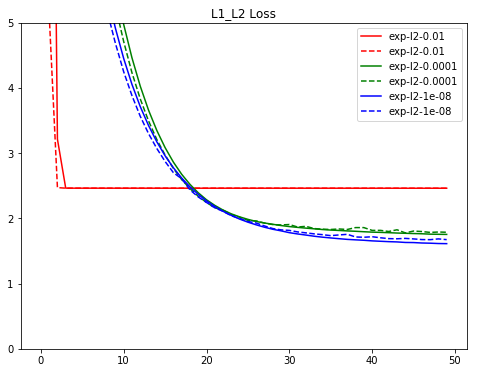

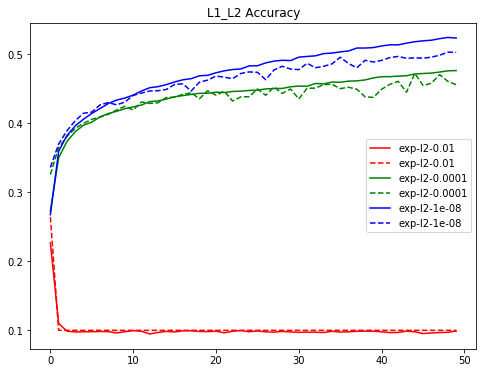

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("L1_L2 Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("L1_L2 Accuracy")
plt.legend()
plt.show()